In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
#!git clone https://github.com/NVlabs/stylegan2.git
#%cd /content/gdrive/My Drive/stylegan2/
%cd /content/gdrive/My Drive/my_data/stylegan2/

/content/gdrive/My Drive/my_data/stylegan2


In [3]:
import dnnlib
import dnnlib.tflib as tflib
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from training import dataset
from dnnlib import EasyDict
from training import misc
from training.networks_stylegan import *
from metrics import metric_base
import dnnlib.tflib.tfutil as tfutil
import os
import PIL.Image
import imageio
import cv2
from tqdm import tqdm_notebook
from datetime import datetime
import copy
plt.rcParams['figure.figsize'] = (11,11)

In [0]:
#ls

In [0]:
#!python run_generator.py generate-images --network=networks/stylegan2-ffhq-config-f.pkl --seeds=100-125 --truncation-psi=0.5 --result-dir=results_img/

In [0]:
import re
def _parse_num_range(s):
    '''Accept either a comma separated list of numbers 'a,b,c' or a range 'a-c' and return as a list of ints.'''
    range_re = re.compile(r'^(\d+)-(\d+)$')
    m = range_re.match(s)
    if m:
        return list(range(int(m.group(1)), int(m.group(2))+1))
    vals = s.split(',')
    return [int(x) for x in vals]

In [0]:
network_pkl = 'networks/stylegan2-ffhq-config-f.pkl'
seeds = _parse_num_range('0-5')
truncation_psi = 0.5
result_dir='results_img/'
col_styles = _parse_num_range('0-1')
minibatch_size=1


In [0]:
def get_path_or_url(path_or_gdrive_path):
    return gdrive_urls.get(path_or_gdrive_path, path_or_gdrive_path)
#----------------------------------------------------------------------------
def load_networks(path_or_url):
    if dnnlib.util.is_url(path_or_url):
        stream = dnnlib.util.open_url(path_or_url, cache_dir='.stylegan2-cache')
    else:
        stream = open(path_or_url, 'rb')
    tflib.init_tf()
    with stream:
        G, D, Gs = pickle.load(stream, encoding='latin1')
    return G, D, Gs

In [9]:
print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = load_networks(network_pkl)
w_avg = Gs.get_var('dlatent_avg') # [component]

Gs_syn_kwargs = dnnlib.EasyDict()
Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_syn_kwargs.randomize_noise = False
Gs_syn_kwargs.minibatch_size = minibatch_size

print('Generating W vectors...')
all_seeds = seeds
all_z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in all_seeds]) # [minibatch, component]
all_w = Gs.components.mapping.run(all_z, None) # [minibatch, layer, component]
all_w = w_avg + (all_w - w_avg) * truncation_psi # [minibatch, layer, component]
w_dict = {seed: w for seed, w in zip(all_seeds, list(all_w))} # [layer, component]

print('Generating images...')
all_images = Gs.components.synthesis.run(all_w, **Gs_syn_kwargs) # [minibatch, height, width, channel]
#image_dict = {(seed, seed): image for seed, image in zip(all_seeds, list(all_images))}

# print('Saving images...')
# for image in all_images:
#   plt.imshow(image)
#   plt.show()
    #PIL.Image.fromarray(image, 'RGB').save(dnnlib.make_run_dir_path('%d.png' % row_seed))


Loading networks from "networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Generating W vectors...
Generating images...


In [0]:
graph = tf.get_default_graph()
input_graph_def = graph.as_graph_def()

In [0]:
output_node_names = ['G_synthesis_1/images_out']


In [0]:
output_graph_def_src = tf.compat.v1.graph_util.convert_variables_to_constants(tf.get_default_session(), input_graph_def, output_node_names)


In [13]:
sub_graph_nodes = []
inputs_replaced_graph_def = tf.GraphDef()
output_node_names = ['G_synthesis_1/images_out']
# for node in tf.get_default_session().graph_def.node:
placeholder_type_enum = tf.float32.as_datatype_enum
for node in tqdm_notebook(output_graph_def_src.node):
    if 'G_synthesis_1' in node.name:
        inputs_replaced_graph_def.node.extend([copy.deepcopy(node)])

output_graph_def = tf.compat.v1.graph_util.extract_sub_graph(inputs_replaced_graph_def, output_node_names)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [0]:
    my_graph = tf.Graph()
    with my_graph.as_default():
        tf.import_graph_def(output_graph_def)
    my_session = tf.Session(graph=my_graph)
    my_graph.get_tensor_by_name('import/G_synthesis_1/dlatents_in:0').set_shape([None,18, 512])

In [15]:
for node in my_session.graph_def.node:
    print(node.name)

import/G_synthesis_1/dlatents_in
import/G_synthesis_1/4x4/Const/const
import/G_synthesis_1/4x4/Const/const/read
import/G_synthesis_1/4x4/Const/Shape
import/G_synthesis_1/4x4/Const/strided_slice/stack
import/G_synthesis_1/4x4/Const/strided_slice/stack_1
import/G_synthesis_1/4x4/Const/strided_slice/stack_2
import/G_synthesis_1/4x4/Const/strided_slice
import/G_synthesis_1/4x4/Const/Tile/multiples/1
import/G_synthesis_1/4x4/Const/Tile/multiples/2
import/G_synthesis_1/4x4/Const/Tile/multiples/3
import/G_synthesis_1/4x4/Const/Tile/multiples
import/G_synthesis_1/4x4/Const/Tile
import/G_synthesis_1/4x4/Conv/strided_slice/stack
import/G_synthesis_1/4x4/Conv/strided_slice/stack_1
import/G_synthesis_1/4x4/Conv/strided_slice/stack_2
import/G_synthesis_1/4x4/Conv/strided_slice
import/G_synthesis_1/4x4/Conv/weight
import/G_synthesis_1/4x4/Conv/weight/read
import/G_synthesis_1/4x4/Conv/mul/y
import/G_synthesis_1/4x4/Conv/mul
import/G_synthesis_1/4x4/Conv/strided_slice_1/stack
import/G_synthesis_1/4x4

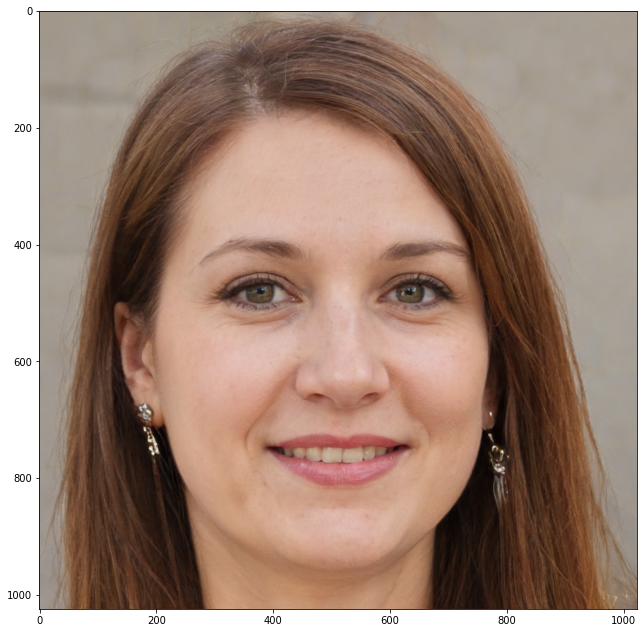

In [16]:
# feed_dict = {'input:0': x_item_in} prefix/G_synthesis_1/dlatents_in
# y_pred = graph.get_tensor_by_name('InceptionV3/Predictions/Reshape_1:0')
feed_dict = {'import/G_synthesis_1/dlatents_in:0': all_w[0:1]}

# y_pred = my_graph.get_tensor_by_name('import/G_synthesis_1/images_out:0')
feed_dict = {'import/G_synthesis_1/dlatents_in:0': all_w[0:1]}
y_pred = my_graph.get_tensor_by_name('import/G_synthesis_1/images_out:0')
pred = my_session.run(y_pred, feed_dict=feed_dict)
plt.imshow(np.clip((np.transpose(pred, (0,2,3,1))[0] + 1)*0.5, 0, 1))

In [17]:
np.outer([1,3, 3,1],[1,3,3,1])

array([[1, 3, 3, 1],
       [3, 9, 9, 3],
       [3, 9, 9, 3],
       [1, 3, 3, 1]])

In [0]:
import os
import numpy as np
import tensorflow as tf
import dnnlib
import dnnlib.tflib as tflib
import dnnlib.tflib.custom_ops as custom_ops
def _get_plugin_upfirdn_2d():
    return custom_ops.get_plugin('dnnlib/tflib/ops/upfirdn_2d.cu')

def _get_plugin_fused_bias_act():
    return custom_ops.get_plugin('dnnlib/tflib/ops/fused_bias_act.cu')

#----------------------------------------------------------------------------

def upfirdn_2d(x, k, upx=1, upy=1, downx=1, downy=1, padx0=0, padx1=0, pady0=0, pady1=0, impl='cuda'):
    r"""Pad, upsample, FIR filter, and downsample a batch of 2D images.
    Accepts a batch of 2D images of the shape `[majorDim, inH, inW, minorDim]`
    and performs the following operations for each image, batched across
    `majorDim` and `minorDim`:
    1. Pad the image with zeros by the specified number of pixels on each side
       (`padx0`, `padx1`, `pady0`, `pady1`). Specifying a negative value
       corresponds to cropping the image.
    2. Upsample the image by inserting the zeros after each pixel (`upx`, `upy`).
    3. Convolve the image with the specified 2D FIR filter (`k`), shrinking the
       image so that the footprint of all output pixels lies within the input image.
    4. Downsample the image by throwing away pixels (`downx`, `downy`).
    This sequence of operations bears close resemblance to scipy.signal.upfirdn().
    The fused op is considerably more efficient than performing the same calculation
    using standard TensorFlow ops. It supports gradients of arbitrary order.
    Args:
        x:      Input tensor of the shape `[majorDim, inH, inW, minorDim]`.
        k:      2D FIR filter of the shape `[firH, firW]`.
        upx:    Integer upsampling factor along the X-axis (default: 1).
        upy:    Integer upsampling factor along the Y-axis (default: 1).
        downx:  Integer downsampling factor along the X-axis (default: 1).
        downy:  Integer downsampling factor along the Y-axis (default: 1).
        padx0:  Number of pixels to pad on the left side (default: 0).
        padx1:  Number of pixels to pad on the right side (default: 0).
        pady0:  Number of pixels to pad on the top side (default: 0).
        pady1:  Number of pixels to pad on the bottom side (default: 0).
        impl:   Name of the implementation to use. Can be `"ref"` or `"cuda"` (default).
    Returns:
        Tensor of the shape `[majorDim, outH, outW, minorDim]`, and same datatype as `x`.
    """

    impl_dict = {
        'ref':  _upfirdn_2d_ref,
        'cuda': _upfirdn_2d_cuda,
    }
    return impl_dict[impl](x=x, k=k, upx=upx, upy=upy, downx=downx, downy=downy, padx0=padx0, padx1=padx1, pady0=pady0, pady1=pady1)

#----------------------------------------------------------------------------

def _upfirdn_2d_ref(x, k, upx, upy, downx, downy, padx0, padx1, pady0, pady1):
    """Slow reference implementation of `upfirdn_2d()` using standard TensorFlow ops."""

    x = tf.convert_to_tensor(x)
    k = np.asarray(k, dtype=np.float32)
    assert x.shape.rank == 4
    inH = x.shape[1].value
    inW = x.shape[2].value
    minorDim = _shape(x, 3)
    kernelH, kernelW = k.shape
    assert inW >= 1 and inH >= 1
    assert kernelW >= 1 and kernelH >= 1
    assert isinstance(upx, int) and isinstance(upy, int)
    assert isinstance(downx, int) and isinstance(downy, int)
    assert isinstance(padx0, int) and isinstance(padx1, int)
    assert isinstance(pady0, int) and isinstance(pady1, int)

    # Upsample (insert zeros).
    x = tf.reshape(x, [-1, inH, 1, inW, 1, minorDim])
    x = tf.pad(x, [[0, 0], [0, 0], [0, upy - 1], [0, 0], [0, upx - 1], [0, 0]])
    x = tf.reshape(x, [-1, inH * upy, inW * upx, minorDim])

    # Pad (crop if negative).
    x = tf.pad(x, [[0, 0], [max(pady0, 0), max(pady1, 0)], [max(padx0, 0), max(padx1, 0)], [0, 0]])
    x = x[:, max(-pady0, 0) : x.shape[1].value - max(-pady1, 0), max(-padx0, 0) : x.shape[2].value - max(-padx1, 0), :]

    # Convolve with filter.
    x = tf.transpose(x, [0, 3, 1, 2])
    x = tf.reshape(x, [-1, 1, inH * upy + pady0 + pady1, inW * upx + padx0 + padx1])
    w = tf.constant(k[::-1, ::-1, np.newaxis, np.newaxis], dtype=x.dtype)
    x = tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='VALID', data_format='NCHW')
    x = tf.reshape(x, [-1, minorDim, inH * upy + pady0 + pady1 - kernelH + 1, inW * upx + padx0 + padx1 - kernelW + 1])
    x = tf.transpose(x, [0, 2, 3, 1])

    # Downsample (throw away pixels).
    return x[:, ::downy, ::downx, :]

#----------------------------------------------------------------------------

def _upfirdn_2d_cuda(x, k, upx, upy, downx, downy, padx0, padx1, pady0, pady1):
    """Fast CUDA implementation of `upfirdn_2d()` using custom ops."""

    x = tf.convert_to_tensor(x)
    k = np.asarray(k, dtype=np.float32)
    majorDim, inH, inW, minorDim = x.shape.as_list()
    kernelH, kernelW = k.shape
    assert inW >= 1 and inH >= 1
    assert kernelW >= 1 and kernelH >= 1
    assert isinstance(upx, int) and isinstance(upy, int)
    assert isinstance(downx, int) and isinstance(downy, int)
    assert isinstance(padx0, int) and isinstance(padx1, int)
    assert isinstance(pady0, int) and isinstance(pady1, int)

    outW = (inW * upx + padx0 + padx1 - kernelW) // downx + 1
    outH = (inH * upy + pady0 + pady1 - kernelH) // downy + 1
    assert outW >= 1 and outH >= 1

    kc = tf.constant(k, dtype=x.dtype)
    gkc = tf.constant(k[::-1, ::-1], dtype=x.dtype)
    gpadx0 = kernelW - padx0 - 1
    gpady0 = kernelH - pady0 - 1
    gpadx1 = inW * upx - outW * downx + padx0 - upx + 1
    gpady1 = inH * upy - outH * downy + pady0 - upy + 1

    @tf.custom_gradient
    def func(x):
        y = _get_plugin_upfirdn_2d().up_fir_dn2d(x=x, k=kc, upx=upx, upy=upy, downx=downx, downy=downy, padx0=padx0, padx1=padx1, pady0=pady0, pady1=pady1)
        y.set_shape([majorDim, outH, outW, minorDim])
        @tf.custom_gradient
        def grad(dy):
            dx = _get_plugin_upfirdn_2d().up_fir_dn2d(x=dy, k=gkc, upx=downx, upy=downy, downx=upx, downy=upy, padx0=gpadx0, padx1=gpadx1, pady0=gpady0, pady1=gpady1)
            dx.set_shape([majorDim, inH, inW, minorDim])
            return dx, func
        return y, grad
    return func(x)



#----------------------------------------------------------------------------

activation_funcs = {
    'linear':   EasyDict(func=lambda x, **_:        x,                          def_alpha=None, def_gain=1.0,           cuda_idx=1, ref='y', zero_2nd_grad=True),
    'relu':     EasyDict(func=lambda x, **_:        tf.nn.relu(x),              def_alpha=None, def_gain=np.sqrt(2),    cuda_idx=2, ref='y', zero_2nd_grad=True),
    'lrelu':    EasyDict(func=lambda x, alpha, **_: tf.nn.leaky_relu(x, alpha), def_alpha=0.2,  def_gain=np.sqrt(2),    cuda_idx=3, ref='y', zero_2nd_grad=True),
    'tanh':     EasyDict(func=lambda x, **_:        tf.nn.tanh(x),              def_alpha=None, def_gain=1.0,           cuda_idx=4, ref='y', zero_2nd_grad=False),
    'sigmoid':  EasyDict(func=lambda x, **_:        tf.nn.sigmoid(x),           def_alpha=None, def_gain=1.0,           cuda_idx=5, ref='y', zero_2nd_grad=False),
    'elu':      EasyDict(func=lambda x, **_:        tf.nn.elu(x),               def_alpha=None, def_gain=1.0,           cuda_idx=6, ref='y', zero_2nd_grad=False),
    'selu':     EasyDict(func=lambda x, **_:        tf.nn.selu(x),              def_alpha=None, def_gain=1.0,           cuda_idx=7, ref='y', zero_2nd_grad=False),
    'softplus': EasyDict(func=lambda x, **_:        tf.nn.softplus(x),          def_alpha=None, def_gain=1.0,           cuda_idx=8, ref='y', zero_2nd_grad=False),
    'swish':    EasyDict(func=lambda x, **_:        tf.nn.sigmoid(x) * x,       def_alpha=None, def_gain=np.sqrt(2),    cuda_idx=9, ref='x', zero_2nd_grad=False),
}

#----------------------------------------------------------------------------

def fused_bias_act(x, b=None, axis=1, act='linear', alpha=None, gain=None, impl='cuda'):
    r"""Fused bias and activation function.
    Adds bias `b` to activation tensor `x`, evaluates activation function `act`,
    and scales the result by `gain`. Each of the steps is optional. In most cases,
    the fused op is considerably more efficient than performing the same calculation
    using standard TensorFlow ops. It supports first and second order gradients,
    but not third order gradients.
    Args:
        x:      Input activation tensor. Can have any shape, but if `b` is defined, the
                dimension corresponding to `axis`, as well as the rank, must be known.
        b:      Bias vector, or `None` to disable. Must be a 1D tensor of the same type
                as `x`. The shape must be known, and it must match the dimension of `x`
                corresponding to `axis`.
        axis:   The dimension in `x` corresponding to the elements of `b`.
                The value of `axis` is ignored if `b` is not specified.
        act:    Name of the activation function to evaluate, or `"linear"` to disable.
                Can be e.g. `"relu"`, `"lrelu"`, `"tanh"`, `"sigmoid"`, `"swish"`, etc.
                See `activation_funcs` for a full list. `None` is not allowed.
        alpha:  Shape parameter for the activation function, or `None` to use the default.
        gain:   Scaling factor for the output tensor, or `None` to use default.
                See `activation_funcs` for the default scaling of each activation function.
                If unsure, consider specifying `1.0`.
        impl:   Name of the implementation to use. Can be `"ref"` or `"cuda"` (default).
    Returns:
        Tensor of the same shape and datatype as `x`.
    """

    impl_dict = {
        'ref':  _fused_bias_act_ref,
        'cuda': _fused_bias_act_cuda,
    }
    return impl_dict[impl](x=x, b=b, axis=axis, act=act, alpha=alpha, gain=gain)

#----------------------------------------------------------------------------

def _fused_bias_act_ref(x, b, axis, act, alpha, gain):
    """Slow reference implementation of `fused_bias_act()` using standard TensorFlow ops."""
    
    # Validate arguments.
    x = tf.convert_to_tensor(x)
    b = tf.convert_to_tensor(b) if b is not None else tf.constant([], dtype=x.dtype)
    act_spec = activation_funcs[act]
    assert b.shape.rank == 1 and (b.shape[0] == 0 or b.shape[0] == x.shape[axis])
    assert b.shape[0] == 0 or 0 <= axis < x.shape.rank
    if alpha is None:
        alpha = act_spec.def_alpha
    if gain is None:
        gain = act_spec.def_gain

    # Add bias.
    if b.shape[0] != 0:
        x += tf.reshape(b, [-1 if i == axis else 1 for i in range(x.shape.rank)])

    # Evaluate activation function.
    x = act_spec.func(x, alpha=alpha)

    # Scale by gain.
    if gain != 1:
        x *= gain

    return x

#----------------------------------------------------------------------------

def _fused_bias_act_cuda(x, b, axis, act, alpha, gain):
    """Fast CUDA implementation of `fused_bias_act()` using custom ops."""

    # Validate arguments.
    x = tf.convert_to_tensor(x)
    empty_tensor = tf.constant([], dtype=x.dtype)
    b = tf.convert_to_tensor(b) if b is not None else empty_tensor
    act_spec = activation_funcs[act]
    assert b.shape.rank == 1 and (b.shape[0] == 0 or b.shape[0] == x.shape[axis])
    assert b.shape[0] == 0 or 0 <= axis < x.shape.rank
    if alpha is None:
        alpha = act_spec.def_alpha
    if gain is None:
        gain = act_spec.def_gain

    # Special cases.
    if act == 'linear' and b is None and gain == 1.0:
        return x
    if act_spec.cuda_idx is None:
        
        return _fused_bias_act_ref(x=x, b=b, axis=axis, act=act, alpha=alpha, gain=gain)

    # CUDA kernel.
    cuda_kernel = _get_plugin_fused_bias_act().fused_bias_act
    cuda_kwargs = dict(axis=axis, act=act_spec.cuda_idx, alpha=alpha, gain=gain)

    # Forward pass: y = func(x, b).
    def func_y(x, b):
        y = cuda_kernel(x=x, b=b, ref=empty_tensor, grad=0, **cuda_kwargs)
        y.set_shape(x.shape)
        return y

    # Backward pass: dx, db = grad(dy, x, y)
    def grad_dx(dy, x, y):
        ref = {'x': x, 'y': y}[act_spec.ref]
        dx = cuda_kernel(x=dy, b=empty_tensor, ref=ref, grad=1, **cuda_kwargs)
        dx.set_shape(x.shape)
        return dx
    def grad_db(dx):
        if b.shape[0] == 0:
            return empty_tensor
        db = dx
        if axis < x.shape.rank - 1:
            db = tf.reduce_sum(db, list(range(axis + 1, x.shape.rank)))
        if axis > 0:
            db = tf.reduce_sum(db, list(range(axis)))
        db.set_shape(b.shape)
        return db

    # Second order gradients: d_dy, d_x = grad2(d_dx, d_db, x, y)
    def grad2_d_dy(d_dx, d_db, x, y):
        ref = {'x': x, 'y': y}[act_spec.ref]
        d_dy = cuda_kernel(x=d_dx, b=d_db, ref=ref, grad=1, **cuda_kwargs)
        d_dy.set_shape(x.shape)
        return d_dy
    def grad2_d_x(d_dx, d_db, x, y):
        ref = {'x': x, 'y': y}[act_spec.ref]
        d_x = cuda_kernel(x=d_dx, b=d_db, ref=ref, grad=2, **cuda_kwargs)
        d_x.set_shape(x.shape)
        return d_x

    # Fast version for piecewise-linear activation funcs.
    @tf.custom_gradient
    def func_zero_2nd_grad(x, b):
        y = func_y(x, b)
        @tf.custom_gradient
        def grad(dy):
            dx = grad_dx(dy, x, y)
            db = grad_db(dx)
            def grad2(d_dx, d_db):
                d_dy = grad2_d_dy(d_dx, d_db, x, y)
                return d_dy
            return (dx, db), grad2
        return y, grad

    # Slow version for general activation funcs.
    @tf.custom_gradient
    def func_nonzero_2nd_grad(x, b):
        y = func_y(x, b)
        def grad_wrap(dy):
            @tf.custom_gradient
            def grad_impl(dy, x):
                dx = grad_dx(dy, x, y)
                db = grad_db(dx)
                def grad2(d_dx, d_db):
                    d_dy = grad2_d_dy(d_dx, d_db, x, y)
                    d_x = grad2_d_x(d_dx, d_db, x, y)
                    return d_dy, d_x
                return (dx, db), grad2
            return grad_impl(dy, x)
        return y, grad_wrap

    # Which version to use?
    if act_spec.zero_2nd_grad:
        return func_zero_2nd_grad(x, b)
    return func_nonzero_2nd_grad(x, b)

def upsample_2d(x, k=None, factor=2, gain=1, data_format='NCHW', impl='cuda'):
    r"""Upsample a batch of 2D images with the given filter.
    Accepts a batch of 2D images of the shape `[N, C, H, W]` or `[N, H, W, C]`
    and upsamples each image with the given filter. The filter is normalized so that
    if the input pixels are constant, they will be scaled by the specified `gain`.
    Pixels outside the image are assumed to be zero, and the filter is padded with
    zeros so that its shape is a multiple of the upsampling factor.
    Args:
        x:            Input tensor of the shape `[N, C, H, W]` or `[N, H, W, C]`.
        k:            FIR filter of the shape `[firH, firW]` or `[firN]` (separable).
                      The default is `[1] * factor`, which corresponds to nearest-neighbor
                      upsampling.
        factor:       Integer upsampling factor (default: 2).
        gain:         Scaling factor for signal magnitude (default: 1.0).
        data_format:  `'NCHW'` or `'NHWC'` (default: `'NCHW'`).
        impl:         Name of the implementation to use. Can be `"ref"` or `"cuda"` (default).
    Returns:
        Tensor of the shape `[N, C, H * factor, W * factor]` or
        `[N, H * factor, W * factor, C]`, and same datatype as `x`.
    """

    assert isinstance(factor, int) and factor >= 1
    if k is None:
        k = [1] * factor
    k = _setup_kernel(k) * (gain * (factor ** 2))
    p = k.shape[0] - factor
    return _simple_upfirdn_2d(x, k, up=factor, pad0=(p+1)//2+factor-1, pad1=p//2, data_format=data_format, impl=impl)

def downsample_2d(x, k=None, factor=2, gain=1, data_format='NCHW', impl='cuda'):
    r"""Downsample a batch of 2D images with the given filter.
    Accepts a batch of 2D images of the shape `[N, C, H, W]` or `[N, H, W, C]`
    and downsamples each image with the given filter. The filter is normalized so that
    if the input pixels are constant, they will be scaled by the specified `gain`.
    Pixels outside the image are assumed to be zero, and the filter is padded with
    zeros so that its shape is a multiple of the downsampling factor.
    Args:
        x:            Input tensor of the shape `[N, C, H, W]` or `[N, H, W, C]`.
        k:            FIR filter of the shape `[firH, firW]` or `[firN]` (separable).
                      The default is `[1] * factor`, which corresponds to average pooling.
        factor:       Integer downsampling factor (default: 2).
        gain:         Scaling factor for signal magnitude (default: 1.0).
        data_format:  `'NCHW'` or `'NHWC'` (default: `'NCHW'`).
        impl:         Name of the implementation to use. Can be `"ref"` or `"cuda"` (default).
    Returns:
        Tensor of the shape `[N, C, H // factor, W // factor]` or
        `[N, H // factor, W // factor, C]`, and same datatype as `x`.
    """

    assert isinstance(factor, int) and factor >= 1
    if k is None:
        k = [1] * factor
    k = _setup_kernel(k) * gain
    p = k.shape[0] - factor
    return _simple_upfirdn_2d(x, k, down=factor, pad0=(p+1)//2, pad1=p//2, data_format=data_format, impl=impl)


def upsample_conv_2d(x, w, k=None, factor=2, gain=1, data_format='NCHW', impl='cuda'):
    r"""Fused `upsample_2d()` followed by `tf.nn.conv2d()`.
    Padding is performed only once at the beginning, not between the operations.
    The fused op is considerably more efficient than performing the same calculation
    using standard TensorFlow ops. It supports gradients of arbitrary order.
    Args:
        x:            Input tensor of the shape `[N, C, H, W]` or `[N, H, W, C]`.
        w:            Weight tensor of the shape `[filterH, filterW, inChannels, outChannels]`.
                      Grouped convolution can be performed by `inChannels = x.shape[0] // numGroups`.
        k:            FIR filter of the shape `[firH, firW]` or `[firN]` (separable).
                      The default is `[1] * factor`, which corresponds to nearest-neighbor
                      upsampling.
        factor:       Integer upsampling factor (default: 2).
        gain:         Scaling factor for signal magnitude (default: 1.0).
        data_format:  `'NCHW'` or `'NHWC'` (default: `'NCHW'`).
        impl:         Name of the implementation to use. Can be `"ref"` or `"cuda"` (default).
    Returns:
        Tensor of the shape `[N, C, H * factor, W * factor]` or
        `[N, H * factor, W * factor, C]`, and same datatype as `x`.
    """

    assert isinstance(factor, int) and factor >= 1

    # Check weight shape.
    w = tf.convert_to_tensor(w)
    assert w.shape.rank == 4
    convH = w.shape[0].value
    convW = w.shape[1].value
    inC = _shape(w, 2)
    outC = _shape(w, 3)
    assert convW == convH

    # Setup filter kernel.
    if k is None:
        k = [1] * factor
    k = _setup_kernel(k) * (gain * (factor ** 2))
    p = (k.shape[0] - factor) - (convW - 1)

    # Determine data dimensions.
    if data_format == 'NCHW':
        stride = [1, 1, factor, factor]
        output_shape = [_shape(x, 0), outC, (_shape(x, 2) - 1) * factor + convH, (_shape(x, 3) - 1) * factor + convW]
        num_groups = _shape(x, 1) // inC
    else:
        stride = [1, factor, factor, 1]
        output_shape = [_shape(x, 0), (_shape(x, 1) - 1) * factor + convH, (_shape(x, 2) - 1) * factor + convW, outC]
        num_groups = _shape(x, 3) // inC

    # Transpose weights.
    w = tf.reshape(w, [convH, convW, inC, num_groups, -1])
    w = tf.transpose(w[::-1, ::-1], [0, 1, 4, 3, 2])
    w = tf.reshape(w, [convH, convW, -1, num_groups * inC])
    w_matr = w
    x = tf.nn.conv2d_transpose(x, w, output_shape=output_shape, strides=stride, padding='VALID', data_format=data_format)
    return _simple_upfirdn_2d(x, k, pad0=(p+1)//2+factor-1, pad1=p//2+1, data_format=data_format, impl=impl),w_matr


def conv_downsample_2d(x, w, k=None, factor=2, gain=1, data_format='NCHW', impl='cuda'):
    r"""Fused `tf.nn.conv2d()` followed by `downsample_2d()`.
    Padding is performed only once at the beginning, not between the operations.
    The fused op is considerably more efficient than performing the same calculation
    using standard TensorFlow ops. It supports gradients of arbitrary order.
    Args:
        x:            Input tensor of the shape `[N, C, H, W]` or `[N, H, W, C]`.
        w:            Weight tensor of the shape `[filterH, filterW, inChannels, outChannels]`.
                      Grouped convolution can be performed by `inChannels = x.shape[0] // numGroups`.
        k:            FIR filter of the shape `[firH, firW]` or `[firN]` (separable).
                      The default is `[1] * factor`, which corresponds to average pooling.
        factor:       Integer downsampling factor (default: 2).
        gain:         Scaling factor for signal magnitude (default: 1.0).
        data_format:  `'NCHW'` or `'NHWC'` (default: `'NCHW'`).
        impl:         Name of the implementation to use. Can be `"ref"` or `"cuda"` (default).
    Returns:
        Tensor of the shape `[N, C, H // factor, W // factor]` or
        `[N, H // factor, W // factor, C]`, and same datatype as `x`.
    """

    assert isinstance(factor, int) and factor >= 1
    w = tf.convert_to_tensor(w)
    convH, convW, _inC, _outC = w.shape.as_list()
    assert convW == convH
    if k is None:
        k = [1] * factor
    k = _setup_kernel(k) * gain
    p = (k.shape[0] - factor) + (convW - 1)
    if data_format == 'NCHW':
        s = [1, 1, factor, factor]
    else:
        s = [1, factor, factor, 1]
    x = _simple_upfirdn_2d(x, k, pad0=(p+1)//2, pad1=p//2, data_format=data_format, impl=impl)
    return tf.nn.conv2d(x, w, strides=s, padding='VALID', data_format=data_format)

#----------------------------------------------------------------------------
# Internal helper funcs.

def _shape(tf_expr, dim_idx):
    if tf_expr.shape.rank is not None:
        dim = tf_expr.shape[dim_idx].value
        if dim is not None:
            return dim
    return tf.shape(tf_expr)[dim_idx]

def _setup_kernel(k):
    k = np.asarray(k, dtype=np.float32)
    if k.ndim == 1:
        k = np.outer(k, k)
    k /= np.sum(k)
    assert k.ndim == 2
    assert k.shape[0] == k.shape[1]
    return k

def _simple_upfirdn_2d(x, k, up=1, down=1, pad0=0, pad1=0, data_format='NCHW', impl='cuda'):
    assert data_format in ['NCHW', 'NHWC']
    assert x.shape.rank == 4
    y = x
    if data_format == 'NCHW':
        y = tf.reshape(y, [-1, _shape(y, 2), _shape(y, 3), 1])
    y = upfirdn_2d(y, k, upx=up, upy=up, downx=down, downy=down, padx0=pad0, padx1=pad1, pady0=pad0, pady1=pad1, impl=impl)
    if data_format == 'NCHW':
        y = tf.reshape(y, [-1, _shape(x, 1), _shape(y, 1), _shape(y, 2)])
    return y

def get_weight(shape, gain=1, use_wscale=True, lrmul=1, weight_var='weight'):
    fan_in = np.prod(shape[:-1]) # [kernel, kernel, fmaps_in, fmaps_out] or [in, out]
    he_std = gain / np.sqrt(fan_in) # He init

    # Equalized learning rate and custom learning rate multiplier.
    if use_wscale:
        init_std = 1.0 / lrmul
        runtime_coef = he_std * lrmul
    else:
        init_std = he_std / lrmul
        runtime_coef = lrmul

    # Create variable.
    init = tf.initializers.random_normal(0, init_std)
    return tf.get_variable(weight_var, shape=shape, initializer=init) * runtime_coef

#----------------------------------------------------------------------------
# Fully-connected layer.

def dense_layer(x, fmaps, gain=1, use_wscale=True, lrmul=1, weight_var='weight'):
    if len(x.shape) > 2:
        x = tf.reshape(x, [-1, np.prod([d.value for d in x.shape[1:]])])
    w = get_weight([x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale, lrmul=lrmul, weight_var=weight_var)
    w = tf.cast(w, x.dtype)
    return tf.matmul(x, w)

#----------------------------------------------------------------------------
# Convolution layer with optional upsampling or downsampling.

def conv2d_layer(x, fmaps, kernel, up=False, down=False, resample_kernel=None, gain=1, use_wscale=True, lrmul=1, weight_var='weight'):
    assert not (up and down)
    assert kernel >= 1 and kernel % 2 == 1
    w = get_weight([kernel, kernel, x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale, lrmul=lrmul, weight_var=weight_var)
    if up:
        x = upsample_conv_2d(x, tf.cast(w, x.dtype), data_format='NCHW', k=resample_kernel)
    elif down:
        x = conv_downsample_2d(x, tf.cast(w, x.dtype), data_format='NCHW', k=resample_kernel)
    else:
        x = tf.nn.conv2d(x, tf.cast(w, x.dtype), data_format='NCHW', strides=[1,1,1,1], padding='SAME')
    return x

#----------------------------------------------------------------------------
# Apply bias and activation func.

def apply_bias_act(x, act='linear', alpha=None, gain=None, lrmul=1, bias_var='bias'):
    b = tf.get_variable(bias_var, shape=[x.shape[1]], initializer=tf.initializers.zeros()) * lrmul
    return fused_bias_act(x, b=tf.cast(b, x.dtype), act=act, alpha=alpha, gain=gain)

#----------------------------------------------------------------------------
# Naive upsampling (nearest neighbor) and downsampling (average pooling).

def naive_upsample_2d(x, factor=2):
    with tf.variable_scope('NaiveUpsample'):
        _N, C, H, W = x.shape.as_list()
        x = tf.reshape(x, [-1, C, H, 1, W, 1])
        x = tf.tile(x, [1, 1, 1, factor, 1, factor])
        return tf.reshape(x, [-1, C, H * factor, W * factor])

def naive_downsample_2d(x, factor=2):
    with tf.variable_scope('NaiveDownsample'):
        _N, C, H, W = x.shape.as_list()
        x = tf.reshape(x, [-1, C, H // factor, factor, W // factor, factor])
        return tf.reduce_mean(x, axis=[3,5])


In [19]:
from keras.layers import Input, Conv2D, Lambda, Layer, InputSpec, LeakyReLU, DepthwiseConv2D, Multiply, Add,Conv2D,Cropping2D,ZeroPadding2D
from keras.layers import Reshape, UpSampling2D, Conv2DTranspose,GlobalAveragePooling2D,AveragePooling2D, Conv2DTranspose, Concatenate
from keras.models import Model
import keras.backend as K

Using TensorFlow backend.


In [0]:

def get_weight(shape, gain=1, use_wscale=True, lrmul=1, weight_var='weight'):
    fan_in = np.prod(shape[:-1]) # [kernel, kernel, fmaps_in, fmaps_out] or [in, out]
    he_std = gain / np.sqrt(fan_in) # He init

    # Equalized learning rate and custom learning rate multiplier.
    if use_wscale:
        init_std = 1.0 / lrmul
        runtime_coef = he_std * lrmul
    else:
        init_std = he_std / lrmul
        runtime_coef = lrmul

    # Create variable.
    init = tf.initializers.random_normal(0, init_std)
    return tf.get_variable(weight_var, shape=shape, initializer=init) * runtime_coef


def dense_layer(x, fmaps, gain=1, use_wscale=True, lrmul=1, weight_var='weight'):
    if len(x.shape) > 2:
        x = tf.reshape(x, [-1, np.prod([d.value for d in x.shape[1:]])])
    w = get_weight([x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale, lrmul=lrmul, weight_var=weight_var)
    w = tf.cast(w, x.dtype)
    return tf.matmul(x, w), w

def apply_bias_act(x, act='linear', alpha=None, gain=None, lrmul=1, bias_var='bias'):
    b = tf.get_variable(bias_var, shape=[x.shape[1]], initializer=tf.initializers.zeros()) * lrmul

    return fused_bias_act(x, b=tf.cast(b, x.dtype), act=act, alpha=alpha, gain=gain),b

def modulated_conv2d_layer(x, y, fmaps, kernel, up=False, down=False, demodulate=True, resample_kernel=None, gain=1,
                                 use_wscale=True, lrmul=1, fused_modconv=True, weight_var='weight', mod_weight_var='mod_weight', 
                                 mod_bias_var='mod_bias', debug_data={}):
  
    stop = debug_data['stop']
    if stop:
      pass
    else:
      transfer_data = debug_data['transfer_data']
      debug_data['stop'] = True

    c_layer = debug_data['out_list']
    # Get weight.
    w = w_main = get_weight([kernel, kernel, x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale, lrmul=lrmul, weight_var=weight_var)
    ww = w[np.newaxis] # [BkkIO] Introduce minibatch dimension.
    # Modulate.
    s, w_dense = _s_dbg, _ = dense_layer(y, fmaps=x.shape[1].value, weight_var=mod_weight_var) # [BI] Transform incoming W to style.
    s,bias_f = apply_bias_act(s, bias_var=mod_bias_var) 
    s=s + 1 # [BI] Add bias (initially 1).
    ww *= tf.cast(s[:, np.newaxis, np.newaxis, :, np.newaxis], w.dtype) # [BkkIO] Scale input feature maps.

    const_shape = int(c_layer.shape[-1])
    if not stop:
      keras_layer_name = (_s_dbg.name).replace(':0','')
      l_layer = debug_data['in_list'][debug_data['layer_idx']]
      l_layer = d_layer = Conv2D(const_shape, (1,1), activation='linear',  name = keras_layer_name)(l_layer)
      transfer_data[keras_layer_name] = {}
      transfer_data[keras_layer_name]['type'] = ['Conv2D1x1BiasOnesNoise']
      transfer_data[keras_layer_name]['in'] = [y.name]
      transfer_data[keras_layer_name]['out'] = [s.name]
      transfer_data[keras_layer_name]['params'] = {'weight': w_dense.name, 'bias': bias_f.name}
      debug_data['transfer_data'].update(transfer_data)

    # Demodulate.
    if demodulate:
        d = tf.rsqrt(tf.reduce_sum(tf.square(ww), axis=[1,2,3]) + 1e-8) # [BO] Scaling factor. 
        ww_d = ww
        ww *= d[:, np.newaxis, np.newaxis, np.newaxis, :] # [BkkIO] Scale output feature maps.
        keras_layer_name = f'const_ones_{str(debug_data["layer_idx"])}'

        o_layer = debug_data['ones_list']

        o_layer = Conv2D(const_shape,(1, 1), name= keras_layer_name)(o_layer)
        transfer_data[keras_layer_name] = {}
        transfer_data[keras_layer_name]['type'] = ['Conv2D1x1BiasOnesWeightsZero']
        transfer_data[keras_layer_name]['in'] = [ww_d.name]
        transfer_data[keras_layer_name]['out'] = [d.name]
        transfer_data[keras_layer_name]['params'] = {'weight': None, 'bias': None}
        debug_data['transfer_data'].update(transfer_data)

        ll_layer = Multiply()([l_layer,l_layer])
        w_layer = Multiply()([o_layer,ll_layer])

        keras_layer_name = (d.name).replace(':0','')
        #w_layer = Lambda(lambda x: x*x*K.ones((1,3,3,const_shape)), name= f'latent_latent_{str(debug_data["layer_idx"])}')(l_layer)
        w_layer = Conv2D(fmaps, (kernel,kernel),name = keras_layer_name,padding='valid')(w_layer)
        w_layer =  Lambda(lambda x: 1/(K.sqrt(x)+K.epsilon()), name = f'1/d_{str(debug_data["layer_idx"])}')(w_layer)

        transfer_data[keras_layer_name] = {}
        transfer_data[keras_layer_name]['type'] = ['Conv2D3x3BiasZerosD']
        transfer_data[keras_layer_name]['in'] = [ww_d.name]
        transfer_data[keras_layer_name]['out'] = [d.name]
        transfer_data[keras_layer_name]['params'] = {'weight': w_main.name, 'bias': None}
        debug_data['transfer_data'].update(transfer_data)

    
    c_layer = Multiply(name = 'const_latent_'+str(debug_data['layer_idx'])+'_'+str(kernel))([c_layer, d_layer])
    # Reshape/scale input.
    if fused_modconv:
        x = tf.reshape(x, [1, -1, x.shape[2], x.shape[3]]) # Fused => reshape minibatch to convolution groups.
        w = tf.reshape(tf.transpose(ww, [1, 2, 3, 0, 4]), [ww.shape[1], ww.shape[2], ww.shape[3], -1])
    else: 
        x *= tf.cast(s[:, :, np.newaxis, np.newaxis], x.dtype) # [BIhw] Not fused => scale input activations.

    const_x = x    
    # Convolution with optional up/downsampling.

    if up:
        x, w_matr = upsample_conv_2d(x, tf.cast(w, x.dtype), data_format='NCHW', k=resample_kernel,impl='cuda')

        keras_layer_name = 'transpose_first_'+str(debug_data["layer_idx"])#(x.name).replace(':0','')
        c_layer = Conv2DTranspose(fmaps, (kernel,kernel),strides =(2,2) ,padding='valid', name = keras_layer_name)(c_layer)

        transfer_data[keras_layer_name] = {}
        transfer_data[keras_layer_name]['type'] = ['Conv2D3x3BiasZerosConstUp']
        transfer_data[keras_layer_name]['in'] = [const_x.name]
        transfer_data[keras_layer_name]['out'] = [x.name]
        transfer_data[keras_layer_name]['params'] = {'weight': w_main.name, 'bias': None}
        debug_data['transfer_data'].update(transfer_data)

        if demodulate:
          c_layer = Multiply(name=f'conv_w_{str(debug_data["layer_idx"])}')([c_layer, w_layer])      

        c_layer = ZeroPadding2D(padding=((1,1), (1,1)))(c_layer)
        keras_layer_name = 'DepthwiseConv2D_'+str(debug_data["layer_idx"])
        c_layer = DepthwiseConv2D((4, 4), padding='valid', name = keras_layer_name)(c_layer)
        transfer_data[keras_layer_name] = {}
        transfer_data[keras_layer_name]['type'] = ['DepthwiseConv2D4х4']
        transfer_data[keras_layer_name]['in'] = [const_x.name]
        transfer_data[keras_layer_name]['out'] = [x.name]
        transfer_data[keras_layer_name]['params'] = {'weight': None, 'bias': None}
        debug_data['transfer_data'].update(transfer_data)

        debug_data['out_list'] = c_layer
    
    elif down:
        print("down")
        1/0
        x = conv_downsample_2d(x, tf.cast(w, x.dtype), data_format='NCHW', k=resample_kernel)
    else:

        x = tf.nn.conv2d(x, tf.cast(w, x.dtype), data_format='NCHW', strides=[1,1,1,1], padding='SAME')

        keras_layer_name = (x.name).replace(':0','')
        c_layer = Conv2D(fmaps, (kernel,kernel),padding='same', name = keras_layer_name)(c_layer)
        if demodulate:
          c_layer = Multiply(name=f'conv_w_{str(debug_data["layer_idx"])}')([c_layer, w_layer])
        transfer_data[keras_layer_name] = {}
        transfer_data[keras_layer_name]['type'] = ['Conv2D3x3BiasZerosConst']
        transfer_data[keras_layer_name]['in'] = [const_x.name]
        transfer_data[keras_layer_name]['out'] = [x.name]
        transfer_data[keras_layer_name]['params'] = {'weight': w_main.name, 'bias': None}
        debug_data['transfer_data'].update(transfer_data)
    
    debug_data['out_list'] = c_layer
   
    # Reshape/scale output
    if fused_modconv:
        x = tf.reshape(x, [-1, fmaps, x.shape[2], x.shape[3]]) # Fused => reshape convolution groups back to minibatch.
    elif demodulate:
        x *= tf.cast(d[:, :, np.newaxis, np.newaxis], x.dtype) # [BOhw] Not fused => scale output activations. 
    debug_data['stop'] = False

    return x, debug_data

In [0]:
global split_input_list, noise_input_list
split_input_list = []
noise_input_list = []
def G_synthesis_stylegan2(
    dlatents_in,                        # Input: Disentangled latents (W) [minibatch, num_layers, dlatent_size].
    dlatent_size        = 512,          # Disentangled latent (W) dimensionality.
    num_channels        = 3,            # Number of output color channels.
    resolution          = 1024,         # Output resolution.
    fmap_base           = 16 << 10,     # Overall multiplier for the number of feature maps.
    fmap_decay          = 1.0,          # log2 feature map reduction when doubling the resolution.
    fmap_min            = 1,            # Minimum number of feature maps in any layer.
    fmap_max            = 512,          # Maximum number of feature maps in any layer.
    randomize_noise     = True,         # True = randomize noise inputs every time (non-deterministic), False = read noise inputs from variables.
    architecture        = 'skip',       # Architecture: 'orig', 'skip', 'resnet'.
    nonlinearity        = 'lrelu',      # Activation function: 'relu', 'lrelu', etc.
    dtype               = 'float32',    # Data type to use for activations and outputs.
    resample_kernel     = [1,3,3,1],    # Low-pass filter to apply when resampling activations. None = no filtering.
    fused_modconv       = True,         # Implement modulated_conv2d_layer() as a single fused op?
    enable_debug=False):                         # Ignore unrecognized keyword args.

    resolution_log2 = int(np.log2(resolution))
    assert resolution == 2**resolution_log2 and resolution >= 4
    def nf(stage): return np.clip(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_min, fmap_max)
    #act, gain = {'relu': (tf.nn.relu, np.sqrt(2)), 'lrelu': (leaky_relu, np.sqrt(2))}[nonlinearity]
    assert architecture in ['orig', 'skip', 'resnet']
    act = nonlinearity
    num_layers = resolution_log2 * 2 - 2
    images_out = None
    #keras
    keras_inputs = []
    #Debug Prints
    out_exprs = {}
    weight_exprs = {}
    transfer_data = {}

    debug_data = {'out_exprs': out_exprs, 'weight_exprs': weight_exprs, 
                  'transfer_data': transfer_data, 'c_layer':[], 'filter_input': [], 
                  'in_list':[], 'in_noise_list':[],'in_noise_const_list':[], 
                  'out_list':[], 'stop':False,'ones_list':[],'output_list_data':[]}

    def add_debug_output(x, prefix=None):
      if(enable_debug):
          d = weight_exprs if not prefix is None else out_exprs
          index = len(d)
          index_str = str(index)
              
          key = x.name
          if not prefix is None:
              key = prefix + '_' + key
                  
          d[key] = x

    # Primary inputs.
    dlatents_in.set_shape([None, num_layers, dlatent_size])
    dlatents_in = tf.cast(dlatents_in, dtype)
    #lod_in = tf.cast(tf.get_variable('lod', initializer=np.float32(0), trainable=False), dtype)

    output_list_data = []
    #Keras inputs
    keras_inputs = []
    # Noise inputs.
    #Keras inputs
    noise_inputs = []
    keras_noise_inputs = []
    for layer_idx in range(num_layers - 1):
        res = (layer_idx + 5) // 2
        shape = [1, 1, 2**res, 2**res]
        noise_inputs.append(tf.get_variable('noise%d' % layer_idx, shape=shape, initializer=tf.initializers.random_normal(), trainable=False))
        
        
        
    def layer(x, layer_idx, fmaps, kernel, up=False, debug_data={}):
        
        x, debug_data = modulated_conv2d_layer(x, dlatents_in[:, layer_idx], fmaps=fmaps, kernel=kernel, up=up,resample_kernel=resample_kernel, fused_modconv=fused_modconv, debug_data=debug_data)
        if layer_idx==0:
          debug_data['output_list_dat'] = debug_data['out_list']

        if randomize_noise:
            noise = tf.random_normal([tf.shape(x)[0], 1, x.shape[2], x.shape[3]], dtype=x.dtype)
        else:
            noise = tf.cast(noise_inputs[layer_idx], x.dtype) 

        noise_strength = tf.get_variable('noise_strength', shape=[], initializer=tf.initializers.zeros())
        
        noise_result = noise * tf.cast(noise_strength, x.dtype)
        x += noise_result
        xx=x
        x, b_noise = apply_bias_act(x, act=act)
        
        keras_layer_name = f'noise_input_{str(layer_idx)}'
        res = (layer_idx + 5) // 2
        shape = ( 2**res, 2**res,1)
        noise_keras = Input(shape = shape, name=keras_layer_name) 

        debug_data['in_noise_list'].append(noise_keras)

        transfer_data[keras_layer_name] = {}
        transfer_data[keras_layer_name]['type'] = ['NoiseInput']
        transfer_data[keras_layer_name]['in'] = [noise.name]
        transfer_data[keras_layer_name]['out'] = [xx.name,x.name,b_noise.name]
        transfer_data[keras_layer_name]['params'] = []
        transfer_data[keras_layer_name]['model_input'] = ['Noise']
        debug_data['transfer_data'].update(transfer_data)


        keras_layer_name = f'noise_const_input_{str(layer_idx)}'
        noise_const_keras = Input(shape = (1,1,1), name=keras_layer_name) 

        debug_data['in_noise_const_list'].append(noise_const_keras)

        transfer_data[keras_layer_name] = {}
        transfer_data[keras_layer_name]['type'] = ['ConstNoiseInput']
        transfer_data[keras_layer_name]['in'] = [noise_strength.name]
        transfer_data[keras_layer_name]['out'] = [noise_result.name]
        transfer_data[keras_layer_name]['params'] = []
        debug_data['transfer_data'].update(transfer_data)

        noise_keras = Multiply()([noise_keras, noise_const_keras])
        c_layer = debug_data['out_list']
        c_layer = Add(name=f'add_{str(debug_data["layer_idx"])}_{str(kernel)}')([noise_keras, c_layer])
        

        keras_layer_name = (f'{x.name}').replace(':0','')
        c_layer = DepthwiseConv2D((1,1), name = keras_layer_name)(c_layer)
        c_layer = LeakyReLU(0.2, name=f'activate_lrelu_{str(debug_data["layer_idx"])}')(c_layer)
        transfer_data[keras_layer_name] = {}
        transfer_data[keras_layer_name]['type'] = ['Conv2D1x1BiasWeightOnes']
        transfer_data[keras_layer_name]['in'] = [xx.name]
        transfer_data[keras_layer_name]['out'] = [x.name]
        transfer_data[keras_layer_name]['params'] = {'weight': None, 'bias': b_noise.name}
        debug_data['transfer_data'].update(transfer_data)

        keras_layer_name = (f'{x.name}').replace(':0','sqrt')
        c_layer = DepthwiseConv2D((1, 1),padding='valid', name = keras_layer_name)(c_layer)     
        transfer_data[keras_layer_name] = {}
        transfer_data[keras_layer_name]['type'] = ['DepthWiseConv2D1x1BiasZeros']
        transfer_data[keras_layer_name]['in'] = [xx.name]
        transfer_data[keras_layer_name]['out'] = [x.name]
        transfer_data[keras_layer_name]['params'] = {'weight': None, 'bias': None}
        debug_data['transfer_data'].update(transfer_data)
        # c_layer = Lambda(lambda x: x*np.sqrt(2), name=f'sqrt2_{str(debug_data["layer_idx"])}')(c_layer)

        

        debug_data['out_list'] = c_layer
        return x, debug_data


    # Building blocks for main layers.
    def block(x, res,debug_data): # res = 3..resolution_log2
        t = x
        with tf.variable_scope('Conv0_up'):
            debug_data['layer_idx'] = res*2-5
            x, debug_data = layer(x, layer_idx=res*2-5, fmaps=nf(res-1), kernel=3, up=True, debug_data=debug_data)

    
        with tf.variable_scope('Conv1'):
            debug_data['layer_idx'] = res*2-4
            x, debug_data = layer(x, layer_idx=res*2-4, fmaps=nf(res-1), kernel=3, debug_data=debug_data)
        return x,debug_data

    def upsample(y, debug_data):
        with tf.variable_scope('Upsample'):
            c_layer = debug_data['out_list']
            f_layer = debug_data['filter_input']
            const_y = y
            y = upsample_2d(y, k=resample_kernel)
            c_layer = UpSampling2D((2,2))(c_layer)
            f_filter = Input((int(c_layer.shape[1]), int(c_layer.shape[2]), 1))
            debug_data['filter_input'].append(f_filter)

            c_layer = Multiply()([c_layer,f_filter])
            c_layer = ZeroPadding2D(padding=((2,1), (2,1)))(c_layer)

            keras_layer_name = 'DepthwiseConv2D_up'+str(debug_data["layer_idx"])
            c_layer = DepthwiseConv2D((4, 4), padding='valid', name = keras_layer_name)(c_layer)
            transfer_data[keras_layer_name] = {}
            transfer_data[keras_layer_name]['type'] = ['DepthwiseConv2D4х4']
            transfer_data[keras_layer_name]['in'] = [const_y.name]
            transfer_data[keras_layer_name]['out'] = [y.name]
            transfer_data[keras_layer_name]['params'] = {'weight': None, 'bias': None}
            debug_data['transfer_data'].update(transfer_data)
            debug_data['out_list'] = c_layer
            return y, debug_data

    def torgb(x, y, res, debug_data): # res = 2..resolution_log2
        with tf.variable_scope('ToRGB'):
            debug_data['layer_idx'] = res*2-3
            xx, debug_data = modulated_conv2d_layer(x, dlatents_in[:, res*2-3], fmaps=num_channels, kernel=1, demodulate=False, fused_modconv=fused_modconv, debug_data=debug_data)
            t, bias = apply_bias_act(xx)

            keras_layer_name = (f'{t.name}').replace(':0','')
            c_layer = debug_data['out_list']
            c_layer = DepthwiseConv2D((1,1), name = keras_layer_name)(c_layer)

            if y is None:
              transfer_data[keras_layer_name] = {}
              transfer_data[keras_layer_name]['type'] = ['Conv2D1x1BiasWeightOnes']
              transfer_data[keras_layer_name]['in'] = [xx.name]
              transfer_data[keras_layer_name]['out'] = [t.name]
              transfer_data[keras_layer_name]['params'] = {'weight': None, 'bias': bias.name}
              debug_data['transfer_data'].update(transfer_data)
              debug_data['out_list'] = c_layer
              return t, debug_data

            else:
              result = y + t
              c_layer = Add()([c_layer, debug_data['y_layer']])
              transfer_data[keras_layer_name] = {}
              transfer_data[keras_layer_name]['type'] = ['Conv2D1x1BiasWeightOnes']
              transfer_data[keras_layer_name]['in'] = [xx.name]
              transfer_data[keras_layer_name]['out'] = [t.name,result.name]
              transfer_data[keras_layer_name]['params'] = {'weight': None, 'bias': bias.name}
              debug_data['transfer_data'].update(transfer_data)
              debug_data['out_list'] = c_layer
              return result, debug_data
    # Early layers.
    y = None
    debug_data['y_layer'] = y

    

    with tf.variable_scope('4x4'):
        with tf.variable_scope('Const'):
            x = tf.get_variable('const', shape=[1, nf(1), 4, 4], initializer=tf.initializers.random_normal())
            x = tf.tile(tf.cast(x, dtype), [tf.shape(dlatents_in)[0], 1, 1, 1])
 
            keras_layer_name = 'const_input'
            const_in_layer = Input((4, 4, nf(1)), name=keras_layer_name)
            transfer_data[keras_layer_name] = {}
            transfer_data[keras_layer_name]['type'] = ['ConstInput']
            transfer_data[keras_layer_name]['in'] = [x.name]
            transfer_data[keras_layer_name]['out'] = [x.name]
            transfer_data[keras_layer_name]['params'] = []
            transfer_data[keras_layer_name]['model_input'] = ['Const']
            debug_data['transfer_data']=transfer_data

            keras_layer_name = 'ones_input'
            ones_in_layer = Input((3, 3, 1), name=keras_layer_name)
            transfer_data[keras_layer_name] = {}
            transfer_data[keras_layer_name]['type'] = ['OnesInput']
            transfer_data[keras_layer_name]['in'] = []
            transfer_data[keras_layer_name]['out'] = []
            transfer_data[keras_layer_name]['params'] = []
            transfer_data[keras_layer_name]['model_input'] = ['Const']
            debug_data['transfer_data']=transfer_data
            debug_data['ones_list'] = ones_in_layer

            for i in range(18):
              in_latent_item = Input([1, 1, nf(1)], name=f'latent_input_{str(i)}')
              debug_data['in_list'].append(in_latent_item)
            debug_data['c_layer'] = const_in_layer
            debug_data['out_list'] = const_in_layer
    
        with tf.variable_scope('Conv'):
            debug_data['layer_idx'] = 0
            x, debug_data = layer(x, layer_idx=0, fmaps=nf(1), kernel=3, debug_data=debug_data)
            debug_data['c_layer'] = debug_data['out_list']
            
            
        if architecture == 'skip':
            y, debug_data = torgb(x, y, 2, debug_data)
            debug_data['y_layer'] = debug_data['out_list']
            

    # # Main layers.
    for res in range(3, resolution_log2 + 1):
        with tf.variable_scope('%dx%d' % (2**res, 2**res)):
            debug_data['out_list'] = debug_data['c_layer']
            x,debug_data = block(x, res, debug_data)
            debug_data['c_layer'] = debug_data['out_list']

            if architecture == 'skip':
                debug_data['out_list'] = debug_data['y_layer']
                y,debug_data = upsample(y, debug_data)
                debug_data['y_layer'] = debug_data['out_list']

            if architecture == 'skip' or res == resolution_log2:
                debug_data['out_list'] = debug_data['c_layer']
                y, debug_data = torgb(x, y, res, debug_data)
                debug_data['y_layer'] = debug_data['out_list']
    images_out = y
    keras_model = Model([const_in_layer] + debug_data['in_list'] + debug_data['in_noise_list'] + debug_data['in_noise_const_list']+ debug_data['filter_input']+[debug_data['ones_list']], 
                        debug_data['out_list'])

    return out_exprs, weight_exprs, keras_model, debug_data


In [22]:
channels = 3
max_features = 512
latent_size = 512
resolution = 1024
batch_size = 1
gpu = 0
resolution_log2 = int(np.log2(resolution))
num_layers = resolution_log2 * 2 - 2
latents = np.random.rand(batch_size, num_layers, latent_size)

with tfutil.absolute_variable_scope("G_dbg", reuse=tf.AUTO_REUSE), tfutil.absolute_name_scope("G_dbg"):
    in_expr = tf.placeholder(tf.float32, name='dlatents_in')
    out_exprs, weight_exprs, keras_model, debug_data_auto = G_synthesis_stylegan2(in_expr,enable_debug=True,randomize_noise=True)



Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [23]:
keras_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent_input_0 (InputLayer)     (None, 1, 1, 512)    0                                            
__________________________________________________________________________________________________
G_dbg/4x4/Conv/MatMul (Conv2D)  (None, 1, 1, 512)    262656      latent_input_0[0][0]             
__________________________________________________________________________________________________
ones_input (InputLayer)         (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
const_ones_0 (Conv2D)           (None, 3, 3, 512)    1024        ones_input[0][0]                 
____________________________________________________________________________________________

In [0]:
def clean_item(in_item):
    if 'ToRGB' in in_item:
        tmp_item = in_item.replace('G_dbg', 'G_synthesis_1').split(':')[0]
        tmp_item = tmp_item.split('/')
        tmp_item[1] = tmp_item[1].split('_')[0]
        return '/'.join(tmp_item)
    else:
        tmp_item = in_item.replace('G_dbg', 'G_synthesis_1').split(':')[0]
        tmp_item = tmp_item.split('/')
        tmp_item[1] = tmp_item[1].split('_')[0]
        return '/'.join(tmp_item)



In [0]:
transfer_data_auto = debug_data_auto['transfer_data']
src_dlatents = all_w[3:4]
feed_dict = {'import/G_synthesis_1/dlatents_in:0': src_dlatents}
data_out_name_list = []
for item in transfer_data_auto:
    for key in ['params', 'out', 'in']:
        for idx in range(len(transfer_data_auto[item][key])):
            if key is not 'params':
               transfer_data_auto[item][key][idx] = clean_item(transfer_data_auto[item][key][idx])
               data_out_name_list.append(transfer_data_auto[item][key][idx])
            else:
               if transfer_data_auto[item][key]['weight'] is None:
                  pass
               else:
                  transfer_data_auto[item][key]['weight'] = clean_item(transfer_data_auto[item][key]['weight'])
                  data_out_name_list.append(transfer_data_auto[item][key]['weight'])
               if transfer_data_auto[item][key]['bias'] is None:
                  pass
               else:
                   transfer_data_auto[item][key]['bias'] = clean_item(transfer_data_auto[item][key]['bias'])
                   data_out_name_list.append(transfer_data_auto[item][key]['bias'])        
                       
output_node_names =  ['G_synthesis_1/dlatents_in', 
                      'G_synthesis_1/4x4/Const/const/read',
                      'G_synthesis_1/8x8/Conv0_up/conv2d_transpose',
                      'G_synthesis_1/8x8/Conv0_up/Reshape_1',
                      'G_synthesis_1/8x8/Conv0_up/IdentityN_1',
                      'G_synthesis_1/8x8/Conv0_up/Reshape_4',
                      'G_synthesis_1/8x8/Upsample/Reshape_1',
                      'G_synthesis_1/8x8/Conv0_up/Const_1',
                      'G_synthesis_1/8x8/Conv0_up/UpFirDn2D',
                      'G_synthesis_1/4x4/Conv/noise_strength'] + data_out_name_list

In [0]:

output_graph_part_def = tf.compat.v1.graph_util.extract_sub_graph(inputs_replaced_graph_def, output_node_names)
part_graph = tf.Graph()
with part_graph.as_default():
    tf.import_graph_def(output_graph_part_def)
part_session = tf.Session(graph=part_graph)

y_pred = [part_graph.get_tensor_by_name('import/' + target_node +':0') for target_node in output_node_names]
pred = part_session.run(y_pred, feed_dict=feed_dict)

In [0]:
for layer in keras_model.layers:
  if layer.name in transfer_data_auto:
    layer_type = transfer_data_auto[layer.name]['type'][0]

    if layer_type=='Conv2D1x1BiasOnesNoise':
        ww, b = layer.get_weights()
        cmp_tf_node = transfer_data_auto[layer.name]['params']['weight']
        w = pred[output_node_names.index(cmp_tf_node)][None,None,...]
        cmp_tf_node = transfer_data_auto[layer.name]['params']['bias']
        b_d = pred[output_node_names.index(cmp_tf_node)]
        layer.set_weights([w, np.ones_like(b)+b_d])

    if layer_type=='Conv2D3x3BiasZerosD':
        _, b = layer.get_weights()
        cmp_tf_node = transfer_data_auto[layer.name]['params']['weight']
        w = pred[output_node_names.index(cmp_tf_node)]
        layer.set_weights([w**2, b*0+K.epsilon()])

    if layer_type=='Conv2D3x3BiasZerosConst':
        _, b = layer.get_weights()
        cmp_tf_node = transfer_data_auto[layer.name]['params']['weight']
        w = pred[output_node_names.index(cmp_tf_node)]
        layer.set_weights([w, b*0])

    if layer_type=='Conv2D3x3BiasZerosConstUp':
        _, b = layer.get_weights()
        cmp_tf_node = transfer_data_auto[layer.name]['params']['weight']      
        w = pred[output_node_names.index(cmp_tf_node)]
        cmp_tf_node = transfer_data_auto[layer.name]['in'][0]      
        x = pred[output_node_names.index(cmp_tf_node)]
        num_groups =  x.shape[1]//w.shape[2]
        w = np.reshape(w,(w.shape[0],w.shape[1],w.shape[2],num_groups,-1))
        w = np.transpose(w[::-1, ::-1], (0, 1, 4, 3, 2))
        w = np.reshape(w, (w.shape[0],w.shape[1], num_groups * w.shape[2],-1)) 
        layer.set_weights([w, b*0])
        
    if layer_type=='Conv2D3x3BiasZerosConstUpFilter':
        w, b = layer.get_weights()
        k = _setup_kernel([1,3,3,1]) * (1 * (2 ** 2))
        k=k[::-1, ::-1, np.newaxis, np.newaxis]
        layer.set_weights([np.ones_like(w)*k, b*0])

    if layer_type=='DepthwiseConv2D4х4':
        w, b = layer.get_weights()
        k = _setup_kernel([1,3,3,1]) * (1 * (2 ** 2))
        k=k[::-1, ::-1, np.newaxis, np.newaxis]
        layer.set_weights([np.ones_like(w)*k, b*0])
     
    if layer_type=='Conv2D1x1BiasWeightOnes':
        w, _ = layer.get_weights()
        cmp_tf_node = transfer_data_auto[layer.name]['params']['bias']
        b = pred[output_node_names.index(cmp_tf_node)]
        layer.set_weights([np.ones_like(w), b])

    if layer_type=='Conv2D1x1BiasOnesWeightsZero':
        w, b = layer.get_weights()
        layer.set_weights([np.ones_like(w), b*0])
      
    if layer_type=='DepthWiseConv2D1x1BiasZeros':
        w, b = layer.get_weights()
        layer.set_weights([np.ones_like(w)*np.sqrt(2), b*0])

        

        
        

        

In [0]:
pred_noise = []
pred_noise_const = []
pred_const= []
for layer in keras_model.layers:
  if layer.name in transfer_data_auto:
    layer_type = transfer_data_auto[layer.name]['type'][0]

    if layer_type=='NoiseInput':
      cmp_tf_node = transfer_data_auto[layer.name]['in'][0]
      data = pred[output_node_names.index(cmp_tf_node)]
      pred_noise.append(np.transpose(data,(0,2,3,1)))

    if layer_type=='ConstNoiseInput':
      cmp_tf_node = transfer_data_auto[layer.name]['in'][0]
      data = pred[output_node_names.index(cmp_tf_node)]
      pred_noise_const.append(data[None,None,None,None,...])

pred_const = pred[output_node_names.index('G_synthesis_1/4x4/Conv/Reshape')]

inputs_keras = []
inputs_keras.append(np.transpose(pred_const,(0,2,3,1)))
for i in range(18):
  inputs_keras.append(src_dlatents[:,i][None,None,...])
inputs_keras = inputs_keras + pred_noise + pred_noise_const


m = np.array([[[1,0],[0,0]]])
for i in [4,8,16,32,64,128,256,512]:
  inputs_keras.append(np.tile(m, (i,i))[...,None])

inputs_keras.append(np.ones((1,3,3,1)))

pred_result = pred[output_node_names.index('G_synthesis_1/1024x1024/ToRGB/add_1')]


In [0]:
#plt.imshow(np.clip((rand_pred[0] + 1)*0.5, 0, 1))
#plt.imshow(np.clip((np.transpose(pred_result, (0,2,3,1))[0] + 1)*0.5, 0, 1))

In [30]:
keras_predict = keras_model.predict(inputs_keras)
np.abs(np.transpose(pred_result[0],(1,2,0)) - keras_predict[0]).mean()

4.0255392e-07

In [0]:
keras_model.save('keras_style2_new_outputs_y_f2.hdf5')


In [32]:
1/4

0.25

In [33]:
#dense
input_data = keras_model.input
output_data = keras_model.get_layer('G_dbg/4x4/Conv/MatMul').output[0]
res_d = K.function(input_data, [output_data])
pred_keras = res_d(inputs_keras)
pred_modul = pred[output_node_names.index('G_synthesis_1/4x4/Conv/add')]
np.abs(pred_modul-pred_keras).mean()

2.142042e-08

In [34]:
#moduled conv
input_data = keras_model.input
output_data = keras_model.get_layer('conv_w_0').output[0]
res_d = K.function(input_data, [output_data])
pred_keras = res_d(inputs_keras)
pred_modul = pred[output_node_names.index('G_synthesis_1/4x4/Conv/Conv2D')]
np.abs(np.transpose(pred_modul,(0,2,3,1))-pred_keras).mean()

2.1328444e-07

In [35]:
#noise input
input_data = keras_model.input
output_data = keras_model.get_layer('noise_input_0').output[0]
res_d = K.function(input_data, [output_data])
pred_keras = res_d(inputs_keras)
pred_modul = pred[output_node_names.index(transfer_data_auto['noise_input_0']['in'][0])]
np.abs(np.transpose(pred_modul[0],(1,2,0))-pred_keras[0]).mean()

0.0

In [36]:
#noise + moduled 
input_data = keras_model.input
output_data = keras_model.get_layer('add_0_3').output[0]
res_d = K.function(input_data, [output_data])
pred_keras = res_d(inputs_keras)
pred_modul = pred[output_node_names.index(transfer_data_auto['noise_input_0']['out'][0])]
np.abs(np.transpose(pred_modul,(0,2,3,1))-pred_keras).mean()


2.1334182e-07

In [37]:
#(noise + moduled)(activate) (#before up block)
input_data = keras_model.input
output_data = keras_model.get_layer('sqrt2_0').output[0]
res_d = K.function(input_data, [output_data])
pred_keras = res_d(inputs_keras)
pred_modul = pred[output_node_names.index('G_synthesis_1/4x4/Conv/IdentityN_1')]
np.abs(np.transpose(pred_modul,(0,2,3,1))-pred_keras).mean()


ValueError: ignored

In [0]:
#dense 8x8
input_data = keras_model.input
output_data = keras_model.get_layer('G_dbg/8x8/Conv0_up/MatMul').output[0]
res_d = K.function(input_data, [output_data])
pred_keras = res_d(inputs_keras)
pred_modul = pred[output_node_names.index('G_synthesis_1/8x8/Conv0_up/add')]
np.abs(pred_modul-pred_keras).mean()

In [0]:
#transpose first
input_data = keras_model.input
output_data = keras_model.get_layer('conv_w_1').output[0]
res_data = K.function(input_data, [output_data])
tf_data = pred[output_node_names.index('G_synthesis_1/8x8/Conv0_up/conv2d_transpose')]
pred_data = res_data(inputs_keras)
np.abs(np.transpose(tf_data,(0,2,3,1))-pred_data).mean()

In [0]:
#DepthwiseConv2D after second transpose
input_data = keras_model.input
output_data = keras_model.get_layer('DepthwiseConv2D_1').output[0]
res_data = K.function(input_data, [output_data])
tf_data = pred[output_node_names.index('G_synthesis_1/8x8/Conv0_up/Reshape_5')]
pred_data = res_data(inputs_keras)
np.abs(np.transpose(tf_data,(0,2,3,1))-pred_data).mean()

In [0]:
#first layer in block with up
input_data = keras_model.input
output_data = keras_model.get_layer('sqrt2_1').output[0]
res_data = K.function(input_data, [output_data])
tf_data = pred[output_node_names.index('G_synthesis_1/8x8/Conv0_up/IdentityN_2')]
pred_data = res_data(inputs_keras)
np.abs(np.transpose(tf_data,(0,2,3,1))-pred_data).mean()

In [0]:
#second layer in block without up (#after up block)
input_data = keras_model.input
output_data = keras_model.get_layer('sqrt2_2').output[0]
res_data = K.function(input_data, [output_data])
tf_data = pred[output_node_names.index('G_synthesis_1/8x8/Conv1/IdentityN_1')]
pred_data = res_data(inputs_keras)
np.abs(np.transpose(tf_data, (0,2,3,1))-pred_data).mean()

In [0]:
#before upsampling
input_data = keras_model.input
output_data = keras_model.get_layer('G_dbg/4x4/ToRGB/IdentityN_1').output[0]
res_data = K.function(input_data, [output_data])

tf_data = pred[output_node_names.index('G_synthesis_1/4x4/ToRGB/IdentityN_1')]

pred_data = res_data(inputs_keras)
np.abs(np.transpose(tf_data, (0,2,3,1))-pred_data).mean()

In [0]:
#after upsampling
input_data = keras_model.input
output_data = keras_model.get_layer('DepthwiseConv2D_up2').output[0]
res_data = K.function(input_data, [output_data])

tf_data = pred[output_node_names.index('G_synthesis_1/8x8/Upsample/Reshape_1')]

pred_data = res_data(inputs_keras)
np.abs(np.transpose(tf_data, (0,2,3,1))-pred_data).mean()

In [0]:
in_layer = c_layer = Input((4, 4, 512))

c_layer = DepthwiseConv2D((1, 1),padding='valid', name = 'second')(c_layer)


model = Model(in_layer, c_layer)
model.summary()

w, b = model.get_layer('second').get_weights()
model.get_layer('second').set_weights([np.ones_like(w)*np.sqrt(2), b*0])

In [0]:
input_data = keras_model.input
output_data = keras_model.get_layer('activate_lrelu_0').output[0]
res_d = K.function(input_data, [output_data])
pred_keras = res_d(inputs_keras)
pred_new = model.predict(pred_keras[0][None,...])
np.abs(np.transpose(pred_modul,(0,2,3,1))-pred_new).mean()

In [0]:
from keras.layers import Concatenate

In [0]:
in_layer = c_layer = Input((4, 4, 3))
in_layer2 = c_layer2 = Input(( 2, 2,1))

#c_layer = Lambda(lambda x :tf.reshape(x,(int(c_layer.shape[1]), 1, int(c_layer.shape[2]), 1, 3)))(c_layer)
#c_layer = Lambda(lambda x :tf.pad(x, [[0, 0], [0, 0], [0, 1], [0, 0], [0, 1], [0, 0]]))(c_layer)
#c_layer = Reshape((int(c_layer.shape[1])*2, int(c_layer.shape[3])*2, 3))(c_layer)

c_layer = UpSampling2D((2,2))(c_layer)

for _ in range(int(np.log2(int(c_layer.shape[1])))-1):
  c_layer2 = Concatenate(1)([c_layer2,c_layer2])

for _ in range(int(np.log2(int(c_layer.shape[2])))-1):
  c_layer2 = Concatenate(2)([c_layer2,c_layer2])

# c_layer = UpSampling2D((2,2))(c_layer)

c_layer = Multiply()([c_layer,c_layer2])


c_layer = ZeroPadding2D(padding=((2,1), (2,1)))(c_layer)
c_layer = DepthwiseConv2D((4, 4),padding='valid', name = 'second')(c_layer)


model = Model([in_layer,in_layer2], c_layer)
model.summary()

k = _setup_kernel([1,3,3,1]) * (1 * (2 ** 2))
k=k[::-1, ::-1, np.newaxis, np.newaxis]
w, b = model.get_layer('second').get_weights()
model.get_layer('second').set_weights([np.ones_like(w)*k, b*0])

In [0]:
out_tf_data = pred[output_node_names.index('G_synthesis_1/8x8/Upsample/Reshape_1')]

In [0]:
in_tf_data = pred[output_node_names.index('G_synthesis_1/4x4/ToRGB/IdentityN_1')]

In [0]:
model_predcit = model.predict([np.transpose(in_tf_data,(0,2,3,1)),np.array([[[[1],[0]],[[0],[0]]]])])

In [0]:
np.abs(np.transpose(out_tf_data,(0,2,3,1)) - model_predcit).mean()

In [0]:
        o_layer = debug_data['ones_list']

        o_layer = Conv2D(const_shape,(1, 1), name= keras_layer_name)(o_layer)
        transfer_data[keras_layer_name] = {}
        transfer_data[keras_layer_name]['type'] = ['Conv2D1x1BiasOnesWeightsZero']
        transfer_data[keras_layer_name]['in'] = [ww_d.name]
        transfer_data[keras_layer_name]['out'] = [d.name]
        transfer_data[keras_layer_name]['params'] = {'weight': None, 'bias': None}
        debug_data['transfer_data'].update(transfer_data)

        ll_layer = Multiply()([l_layer,l_layer])
        w_layer = Multiply()([o_layer,ll_layer])

        keras_layer_name = (d.name).replace(':0','')

In [0]:
resample_kernel = [1,3,3,1]
x_cuda, w_up = upsample_conv_2d(tf.cast(x_data, x_data.dtype), tf.cast(w_data, x_data.dtype), data_format='NCHW', k=resample_kernel,impl='cuda')
x_ref, w_up = upsample_conv_2d(tf.cast(x_data, x_data.dtype), tf.cast(w_data, x_data.dtype), data_format='NCHW', k=resample_kernel,impl='ref')




In [0]:
input_1 = l_layer = Input(shape=(1,1,512))
input_2 = c_layer = Input(shape=(4,4,512))


d_layer = l_layer
# w_laer = Multiply()(][l_layer,l_layer])
w_layer = Lambda(lambda x: x*x*K.ones((1,3,3,512)))(l_layer)

w_layer = Conv2D(512, (3,3),name = 'conv_w2',padding='valid')(w_layer)

w_layer =  Lambda(lambda x: 1/K.sqrt(x), name='d')(w_layer)

c_layer = Multiply()([c_layer, d_layer])
c_layer = Conv2DTranspose(512, (3,3), strides=(2,2), padding='valid', name = 'conv_w')(c_layer)

c_layer = Multiply()([c_layer, w_layer])
c_layer 

out_layer = c_layer

model_test = Model([input_1,input_2], out_layer)
model_test.summary()

In [0]:
l_data = pred[output_node_names.index('G_synthesis_1/8x8/Conv0_up/add')]
c_data = pred[output_node_names.index('G_synthesis_1/4x4/Conv/IdentityN_1')]

In [0]:
ker_predict = model_test.predict([l_data[None,None,...],np.transpose(c_data, (0,2,3,1))])

In [0]:
tf_data = pred[output_node_names.index('G_synthesis_1/8x8/Conv0_up/conv2d_transpose')]

In [0]:
(np.abs(np.transpose(tf_data,(0,2,3,1)) - ker_predict)).mean()

In [0]:
ker_predict

In [0]:

cmp_tf_node = transfer_data_auto[layer.name]['params']['weight']
        w = pred[output_node_names.index(cmp_tf_node)]
        layer.set_weights([w, b*0])

In [0]:
in_layer = c_layer = Input((9,9, 512))
c_layer = ZeroPadding2D(padding=((1,1), (1,1)))(c_layer)
c_layer = DepthwiseConv2D((4, 4), padding='valid', name = 'second_trans')(c_layer)

model = Model(in_layer, c_layer)
model.summary()
k = _setup_kernel([1,3,3,1]) * (1 * (2 ** 2))
k=k[::-1, ::-1, np.newaxis, np.newaxis]
w, b = model.get_layer('second_trans').get_weights()
#model.get_layer('second_trans').set_weights([np.ones_like(w)*k, b*0])
print((np.ones_like(w)).shape)

In [0]:
in_tf_data_trans = pred[output_node_names.index('G_synthesis_1/8x8/Conv0_up/conv2d_transpose')]
out_tf_data_trans = pred[output_node_names.index(transfer_data_auto['transpose_first_1']['out'][0])]
predict_trans = model.predict(np.transpose(in_tf_data_trans, (0,2,3,1)))
(np.abs(np.transpose(out_tf_data_trans,(0,2,3,1)) - predict_trans)).mean()


In [0]:
transfer_data_auto['transpose_first_1']['out'][0]

In [0]:
output_node_names.index(transfer_data_auto['transpose_first_1']['out'][0])

In [0]:
out_tf_data_trans.shape

In [0]:
!pip3 install coremltools

In [0]:
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import coremltools
from coremltools.models import MLModel

In [0]:
import tensorflow as tf

In [0]:
netGA=load_model('keras_style2.hdf5')

In [0]:

coreml_model_GA = coremltools.converters.keras.convert(netGA,
                                                       add_custom_layers=False,
                                                       custom_conversion_functions={})

In [0]:
coreml_model_GA.save('coreml_model_GA.mlmodel')


In [0]:
coreml_model_GA =  MLModel('coreml_model_GA.mlmodel')

In [0]:
in_dict = {'input1': (np.transpose(image_to_predict/255*2-1,(2, 0, 1)))[None,None,...]}


In [0]:
in_dict_test = {}
num=0
for i in range(1,45):
  input_data={}
  input_data['input'+str(i)]=np.transpose(inputs_keras[num],(0,3,1,2))[None,...]
  num+=1
  in_dict_test.update(input_data)



In [0]:
coreml_model_GA

In [0]:


out_dict = coreml_model_GA.predict(in_dict_test)

predict_image =np.transpose(out_dict['output1'], (1,2,0))

In [0]:
for data in inputs_keras:
  print(data.shape)

In [0]:

n = pred[output_node_names.index('G_synthesis_1/4x4/Conv/noise_strength')]

In [0]:
const_lat_noise

In [0]:
mu, sigma = 0, 1 
rand_data=[]


rand_data.append(np.transpose(pred[output_node_names.index('G_synthesis_1/4x4/Conv/Reshape')],(0,2,3,1)))

seed=5
test_data = np.random.RandomState(seed).randn(1,512)
test_latent_1 = Gs.components.mapping.run(test_data, None)

for i in range(18):
  rand_data.append(test_latent_1[:,i][None,None,...])

#noise
for i in range(19,36):
  b,h,w,c = keras_model.inputs[i].get_shape().as_list()
  rand_data.append(np.random.RandomState(seed).randn(1,h,w,c))

rand_data = rand_data + pred_noise_const
m = np.array([[[1,0],[0,0]]])
for i in [4,8,16,32,64,128,256,512]:
  rand_data.append(np.tile(m, (i,i))[...,None])

rand_pred = keras_model.predict(rand_data)
plt.imshow(np.clip((rand_pred[0] + 1)*0.5, 0, 1))


In [0]:
mu, sigma = 0, 1 
rand_data=[]


rand_data.append(np.transpose(pred[output_node_names.index('G_synthesis_1/4x4/Conv/Reshape')],(0,2,3,1)))
#rand_data.append(np.random.normal(mu, sigma, (1,4,4,512)))
#latents

seed=1
test_data = np.random.RandomState(seed).randn(1,512)
test_latent_2 = Gs.components.mapping.run(test_data, None)

for i in range(18):
  rand_data.append(test_latent_2[:,i][None,None,...])

#noise
for i in range(19,36):
  b,h,w,c = keras_model.inputs[i].get_shape().as_list()
  rand_data.append(np.random.RandomState(seed).randn(1,h,w,c))

rand_data = rand_data + pred_noise_const
m = np.array([[[1,0],[0,0]]])
for i in [4,8,16,32,64,128,256,512]:
  rand_data.append(np.tile(m, (i,i))[...,None])

rand_pred = keras_model.predict(rand_data)
plt.imshow(np.clip((rand_pred[0] + 1)*0.5, 0, 1))


In [0]:
mu, sigma = 0, 1 
rand_data=[]


rand_data.append(np.transpose(pred[output_node_names.index('G_synthesis_1/4x4/Conv/Reshape')],(0,2,3,1)))
#rand_data.append(np.random.normal(mu, sigma, (1,4,4,512)))
#latents

third = test_latent_1*0.5 + test_latent_2*0.5

for i in range(18):
  rand_data.append(third[:,i][None,None,...])

#noise
for i in range(19,36):
  b,h,w,c = keras_model.inputs[i].get_shape().as_list()
  rand_data.append(np.random.RandomState(seed).randn(1,h,w,c))

rand_data = rand_data + pred_noise_const
m = np.array([[[1,0],[0,0]]])
for i in [4,8,16,32,64,128,256,512]:
  rand_data.append(np.tile(m, (i,i))[...,None])

rand_pred = keras_model.predict(rand_data)
plt.imshow(np.clip((rand_pred[0] + 1)*0.5, 0, 1))


In [0]:
mu, sigma = 0, 1 
rand_data=[]


rand_data.append(np.transpose(pred[output_node_names.index('G_synthesis_1/4x4/Conv/Reshape')],(0,2,3,1)))
#rand_data.append(np.random.normal(mu, sigma, (1,4,4,512)))
#latents

third = test_latent_1*0.5 + test_latent_2*0.5

for i in range(18):
  rand_data.append(third[:,i][None,None,...])

#noise
for i in range(19,36):
  b,h,w,c = keras_model.inputs[i].get_shape().as_list()
  rand_data.append(np.random.RandomState(seed).randn(1,h,w,c))

rand_data = rand_data + pred_noise_const
m = np.array([[[1,0],[0,0]]])
for i in [4,8,16,32,64,128,256,512]:
  rand_data.append(np.tile(m, (i,i))[...,None])

rand_pred = keras_model.predict(rand_data)
plt.imshow(np.clip((rand_pred[0] + 1)*0.5, 0, 1))


In [0]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [0]:
import json
from json import JSONEncoder
import numpy
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

numpyArrayOne = numpy.array([[11, 22, 33], [44, 55, 66], [77, 88, 99]])

# Serialization
numpyData = {'const': ((np.transpose(pred[output_node_names.index('G_synthesis_1/4x4/Conv/Reshape')],(0,2,3,1)))),
             'const_noise': pred_noise_const,
             'latent_1': test_latent_2,
             'latent_5': test_latent_1
              }
encodedNumpyData = json.dumps(numpyData, cls=NumpyArrayEncoder)
with open('data_new.json', 'w') as outfile:
    json.dump(encodedNumpyData, outfile)


In [0]:
r

In [0]:
r.append(test_latent_1)

In [0]:
r1 = np.array(r)

In [0]:
r1.shape

In [0]:
np.save('latent.npy',r1)

In [0]:
((np.transpose(pred[output_node_names.index('G_synthesis_1/4x4/Conv/Reshape')],(0,2,3,1)))).save('const.npy')

In [0]:
with open("numpyData.json", "w") as write_file:
    json.dump(encodedNumpyData, write_file)

In [0]:
with open("numpyData.json", "r") as read_file:
    print("Converting JSON encoded data into Numpy array")
    decodedArray = json.load(read_file)

In [0]:
decodedArray

In [0]:
json_data = {'const': ((np.transpose(pred[output_node_names.index('G_synthesis_1/4x4/Conv/Reshape')],(0,2,3,1)))).tolist(),
             'const_noise': pred_noise_const,
             'latent_1': test_latent_2.tolist(),
             'latent_5': test_latent_1.tolist()
              }

In [0]:
json_dump = json.dumps(json_data)

In [0]:
import json
with open('data_new.json', 'w') as outfile:
    json.dump(json_data, outfile)

In [0]:
all_z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in all_seeds]) # [minibatch, component]
all_w = Gs.components.mapping.run(all_z, None) # [minibatch, layer, component]

In [0]:
seed=1
test_data = np.random.RandomState(seed).randn(1,512)
test_latent = Gs.components.mapping.run(test_data, None)
test_latent = test_latent[:,None,:,:]
test_latent.shape

In [0]:
pred[output_node_names.index('G_synthesis_1/4x4/Conv/Reshape')].shape

In [0]:

mapping network


In [0]:
7

In [0]:
UpSampling2D

In [0]:
in_layer = c_layer = Input((1,1, 512))

c_layer = UpSampling2D((3, 3))(c_layer)
c_layer = Conv2D(512,(1, 1))(c_layer)

model = Model(in_layer, c_layer)
model.summary()